In [1]:
# Data processing/formatting
from sklearn.preprocessing import MinMaxScaler
from seqprops import SequentialPropertiesEncoder

# for building vae model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D, Dropout, RepeatVector, TimeDistributed, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# classic required packages
import os
import random
import pandas as pd
import numpy as np
from pylab import rcParams
import importlib
import importlib.resources

# packages for graphics
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file = 'amp.csv'
df = pd.read_csv(file)
# sequences = pd.read_csv(file, usecols=['sequence']).iloc[:, 0].values
# sequence_type = pd.read_csv(file, usecols=['label']).iloc[:, 0].values

sequences = df.loc[:, 'sequence'].values
sequences_type = df.loc[:, 'label'].values
print(sequences)
print(sequences_type)

# Determine the length of the longest sequence
max_seq_len = 0
for sequence in sequences:
    max_seq_len = max(len(sequence), max_seq_len)
print("Max sequence length: ", max_seq_len)

['GEP' 'QHP' 'YLRF' ...
 'MGSPEKLRPSDFSKSFLISSIRFAMSFSSFELYSACSSLIRVSSPTMAET'
 'MLLPATMSDKPDMAEIEKFDKSKLKKTETQEKNPLPSKETIEQEKQAGES'
 'GATIKKCVVDVKLSKPCTFQECQPLCLQKYNGNGLCPGDDNNICACVYNC']
[0 0 0 ... 0 0 1]
Max sequence length:  50


In [3]:
df['label'].value_counts()

0    5701
1    3708
Name: label, dtype: int64

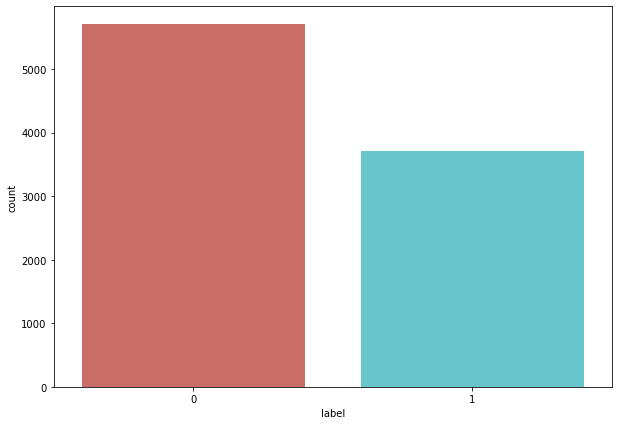

<Figure size 720x504 with 0 Axes>

In [4]:
rcParams['figure.figsize'] =  10,7
sns.countplot(x = 'label', data=df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [5]:
### TRAIN TEST SPLIT ###
encoder = SequentialPropertiesEncoder(scaler=MinMaxScaler(feature_range=(-1, 1)), max_seq_len=max_seq_len, stop_signal=True)
all_seq_encoded = encoder.encode(sequences)
train_size = 0.8

print("Shape of all sequences: ", all_seq_encoded.shape)
train_size = 0.8

# dal ja ovo uopce dobro kad mi target zapravo nije sequence (zadan kao takav) i zapravo ne mogu provjerit validnost samog vae
# bez nekog drugog nezavisnog modela
sequence_input_train = all_seq_encoded[:int(len(all_seq_encoded) * train_size)]
sequence_input_test = all_seq_encoded[int(len(all_seq_encoded) * train_size):]
print(sequence_input_train.shape, sequence_input_test.shape)

sequence_target_train = sequences_type[:int(len(sequences_type) * train_size)]
sequence_target_test = sequences_type[int(len(sequences_type) * train_size):]
print(sequence_target_train.shape, sequence_target_test.shape)

Shape of all sequences:  (9409, 51, 95)
(7527, 51, 95) (1882, 51, 95)
(7527,) (1882,)


In [6]:
# TODO: pitat kako tocno SequentialPropertiesEncoder radi - da znam objasnit u radu (kako tocno radi encode)
encoder = SequentialPropertiesEncoder(scaler=MinMaxScaler(feature_range=(-1, 1)))

# onuhunitsiksti_seq = sequences[:160]
all_seq = sequences
X = encoder.encode(all_seq)

# to see what data looks like
print(X[:2])

# Batch = 1 or more Samples
# encoder_shape = (Samples, Time Steps, Features)
encoder_shape = X.shape
print(encoder_shape)

# currently hardcoding shape for input data
shape = X.shape[1:]
print(shape)

[[[-0.18       -0.02195609 -0.94716981 ...  0.07430998  1.
    0.        ]
  [-0.64       -0.15768463 -0.64528302 ...  0.08195329 -0.2617096
    0.        ]
  [-0.02        0.49301397  0.47169811 ... -0.04883227 -1.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    1.        ]
  [ 0.          0.          0.         ...  0.          0.
    1.        ]
  [ 0.          0.          0.         ...  0.          0.
    1.        ]]

 [[-0.72       -0.30538922 -1.         ...  0.07940552 -0.23770492
    0.        ]
  [-0.68       -0.0259481  -0.53962264 ...  0.95923567 -0.47716628
    0.        ]
  [-0.02        0.49301397  0.47169811 ... -0.04883227 -1.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    1.        ]
  [ 0.          0.          0.         ...  0.          0.
    1.        ]
  [ 0.          0.          0.         ...  0.          0.
    1.        ]]]
(9409, 51, 95)
(51, 95)


In [7]:
# encoder model definition
def create_seq_encoder_model(input_shape, latent_dim=2, lstm_cells=64):
    inp = Input(shape=input_shape, name="input_1_enc")
    
    x = LSTM(lstm_cells, unroll=True, name="lstm_enc")(inp)
    z = Dense(16, activation='relu', name="output_dense_enc")(x)
    # TODO: pitat kolika bi latentna dimenzija trebala bit (di god sam gledo 2 se koristi)
    z_mean = Dense(latent_dim)(z)
    z_log_sigma = Dense(latent_dim)(z)
    
    encoder_model = Model(inputs=inp, outputs=[z_mean, z_log_sigma], name="encoder")
    return encoder_model

In [8]:
# decoder model definition
def create_seq_decoder_model(input_shape, latent_dim=2, lstm_cells=64):
    model_input = Input(shape=(latent_dim,), name="input_1_dec")
#   repeating for the number of time steps
    x = RepeatVector(input_shape[0])(model_input)
#   return_sequences - whether to return the last output in the output sequence, or the full sequence
    x = LSTM(lstm_cells, unroll=True, name="lstm_dec", return_sequences=True)(x)
#   applies layer for every temporal slice of an input - feature
    out = TimeDistributed(Dense(input_shape[1]))(x)
    
    decoder_model = Model(inputs=model_input, outputs=out, name="decoder")
    return decoder_model

In [9]:
# setting latent space to 2 dimension
latent_dim = 2

# setting fixed randomizer
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

# sampling from latent space
def sampling(args):
    
    z_mean, z_log_sigma = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

# loss function defined from reconstruction param and regularisation term (expressed as the Kulback-Leibler (KL) divergence)
def vae_loss(inp, reconstruction, z_log_sigma, z_mean):
    
    kl_loss = tf.reduce_mean(-0.5 * tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1))
    
#   binary_crossentropy se koristi u inace (dobivam negativni loss), zato je tu postalvjen mean_squared_error
#   Use this cross-entropy loss for binary (0 or 1) classification applications
    reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(inp, reconstruction), axis=1
                )
            )
    
    return reconstruction_loss + kl_loss

def get_model():
    
    set_seed(31)
    
    ### encoder ###
    encoder = create_seq_encoder_model(input_shape=shape)  # shape (Time Steps, Features)
    encoder.summary()

    ### decoder ###
    decoder = create_seq_decoder_model(input_shape=shape, latent_dim=2)
    decoder.summary()

    ### encoder + decoder ###
    inp = Input(shape=shape, name="vae_encoder_input")
    z_mean, z_log_sigma = encoder(inp)
    z = Lambda(sampling)([z_mean, z_log_sigma])
     
    reconstruction = decoder(z)
    
    vae = Model(inp, reconstruction, name="vae_model")
    vae.add_loss(vae_loss(inp, reconstruction, z_log_sigma, z_mean))
    vae.compile(optimizer=keras.optimizers.Adam())
    
    return vae, encoder, decoder

In [10]:
es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
vae, enc, dec = get_model()
# mnogi fitaju tu dva put - sequence_input_train (dal je to radi greske il ne)
# https://blog.keras.io/building-autoencoders-in-keras.html
vae.fit(sequence_input_train, sequence_target_train,
         batch_size=128, epochs=100, validation_split=0.2, shuffle=False, callbacks=[es])

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_enc (InputLayer)       [(None, 51, 95)]     0           []                               
                                                                                                  
 lstm_enc (LSTM)                (None, 64)           40960       ['input_1_enc[0][0]']            
                                                                                                  
 output_dense_enc (Dense)       (None, 16)           1040        ['lstm_enc[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 2)            34          ['output_dense_enc[0][0]']       
                                                                                            

In [11]:
### LATENT REPRESENTATION ON TEST DATA ###

enc_pred, _ = enc.predict(sequence_input_test, batch_size=128)
enc_pred.shape

15/15 [==============================] - 1s 19ms/step


(1882, 2)

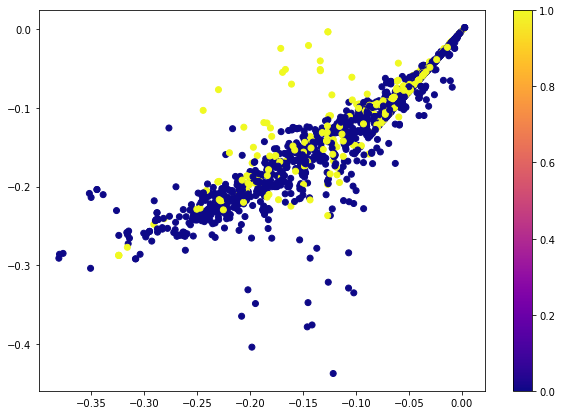

In [12]:
plt.scatter(enc_pred[:,0], enc_pred[:,1], c=sequence_target_test ,cmap='plasma')
plt.colorbar()
plt.show()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_enc (InputLayer)       [(None, 51, 95)]     0           []                               
                                                                                                  
 lstm_enc (LSTM)                (None, 64)           40960       ['input_1_enc[0][0]']            
                                                                                                  
 output_dense_enc (Dense)       (None, 16)           1040        ['lstm_enc[0][0]']               
                                                                                                  
 dense_3 (Dense)                (None, 2)            34          ['output_dense_enc[0][0]']       
                                                                                            

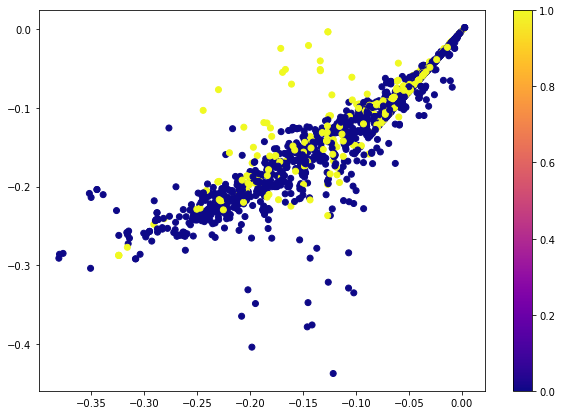

In [13]:
es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
vae, enc, dec = get_model()

vae.fit(sequence_input_train,
         batch_size=128, epochs=100, validation_split=0.2, shuffle=False, callbacks=[es])

enc_pred, _ = enc.predict(sequence_input_test, batch_size=128)
enc_pred.shape
plt.scatter(enc_pred[:,0], enc_pred[:,1], c=sequence_target_test ,cmap='plasma')
plt.colorbar()
plt.show()